<a href="https://colab.research.google.com/github/bkim9/Resume/blob/main/21_10_Deep_Factorization_Machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l==1.0.3
!pip install -U mxnet-cu112==1.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 95.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 101.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 MB 3.2 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [ ]:
import os
from mxnet import gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

In [ ]:
class DeepFM(nn.Block):
    def __init__(self, field_dims, num_factors, mlp_dims, drop_rate=0.1):
        super(DeepFM, self).__init__()
        num_inputs = int(sum(field_dims))
        self.embedding = nn.Embedding(num_inputs, num_factors)
        self.fc = nn.Embedding(num_inputs, 1)
        self.linear_layer = nn.Dense(1, use_bias=True)
        input_dim = self.embed_output_dim = len(field_dims) * num_factors
        self.mlp = nn.Sequential()
        for dim in mlp_dims:
            self.mlp.add(nn.Dense(dim, 'relu', True, in_units=input_dim))
            self.mlp.add(nn.Dropout(rate=drop_rate))
            input_dim = dim
        self.mlp.add(nn.Dense(in_units=input_dim, units=1))

    def forward(self, x):
        embed_x = self.embedding(x)
        square_of_sum = np.sum(embed_x, axis=1) ** 2
        sum_of_square = np.sum(embed_x ** 2, axis=1)
        inputs = np.reshape(embed_x, (-1, self.embed_output_dim))
        x = self.linear_layer(self.fc(x).sum(1)) \
            + 0.5 * (square_of_sum - sum_of_square).sum(1, keepdims=True) \
            + self.mlp(inputs)
        x = npx.sigmoid(x)
        return x

loss 0.509, train acc 0.485, test acc 0.512
73082.8 examples/sec on [gpu(0)]


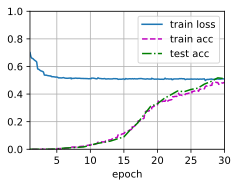

In [ ]:
batch_size = 2048
data_dir = d2l.download_extract('ctr')
train_data = d2l.CTRDataset(os.path.join(data_dir, 'train.csv'))
test_data = d2l.CTRDataset(os.path.join(data_dir, 'test.csv'),
                           feat_mapper=train_data.feat_mapper,
                           defaults=train_data.defaults)
field_dims = train_data.field_dims
train_iter = gluon.data.DataLoader(
    train_data, shuffle=True, last_batch='rollover', batch_size=batch_size,
    num_workers=d2l.get_dataloader_workers())
test_iter = gluon.data.DataLoader(
    test_data, shuffle=False, last_batch='rollover', batch_size=batch_size,
    num_workers=d2l.get_dataloader_workers())
devices = d2l.try_all_gpus()
net = DeepFM(field_dims, num_factors=10, mlp_dims=[30, 20, 10])
net.initialize(init.Xavier(), ctx=devices)
lr, num_epochs, optimizer = 0.01, 30, 'adam'
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {'learning_rate': lr})
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)